# MINE4201- SR -  Laboratorio 1 
# Exploración modelos KNN



Vamos a utilizar las siguientes librerias en el laboratorio


In [1]:
!pip install "numpy>=1.25.0,<2.0.0"
!pip install scikit-surprise
!pip install pandas
!pip install matplotlib

In [2]:
pwd

'c:\\Users\\jeron\\OneDrive\\Escritorio\\Programacion\\Laboratorio-1-Sistemas-de-Recomentacion\\lab01'

In [7]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random
import matplotlib.pyplot as plt

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [4]:
if not (os.path.exists('/home/valentina/uniandes/MINE4201-2025/labs/lab01/u.data') and os.path.exists('/home/valentina/uniandes/MINE4201-2025/labs/lab01/u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

ValueError: Los archivos u.data e u.item no fueron encontrados en el path

In [3]:
ratings=pd.read_csv('u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [4]:
items=pd.read_csv('u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1', engine='python' )

Verifique que los ratings y los items hayan sido cargados correctamente





In [ ]:
#ratings.rating=ratings.rating.astype('category')
ratings.head()

In [ ]:
items.head()

## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

In [ ]:
ratings.rating.hist()

## En la siguiente celda se esta calculando el número de ratings por usuario y  el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [5]:
ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)

,count,mean
user_id,,
405,737,1.834464
655,685,2.908029
13,636,3.097484
450,540,3.864815
276,518,3.465251
...,...,...
685,20,2.050000
475,20,3.600000
36,20,3.800000


In [6]:
ratings.groupby('user_id')['rating'].mean().reset_index()

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


##Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

¿Cómo es la distribución del promedio de calificación por usuario?


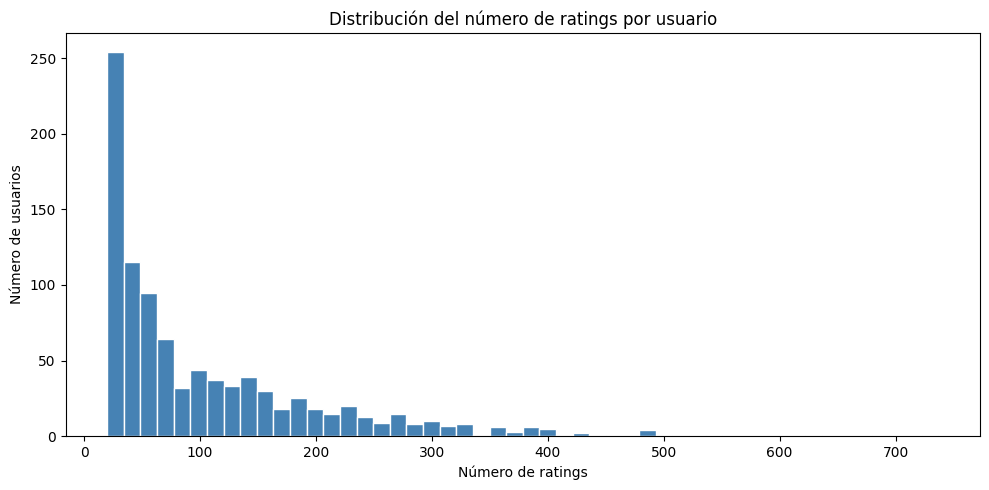

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64


In [8]:
ratings_per_user = ratings.groupby('user_id')['rating'].count()

plt.figure(figsize=(10, 5))
plt.hist(ratings_per_user, bins=50, color='steelblue', edgecolor='white')
plt.title('Distribución del número de ratings por usuario')
plt.xlabel('Número de ratings')
plt.ylabel('Número de usuarios')
plt.tight_layout()
plt.show()

print(ratings_per_user.describe())

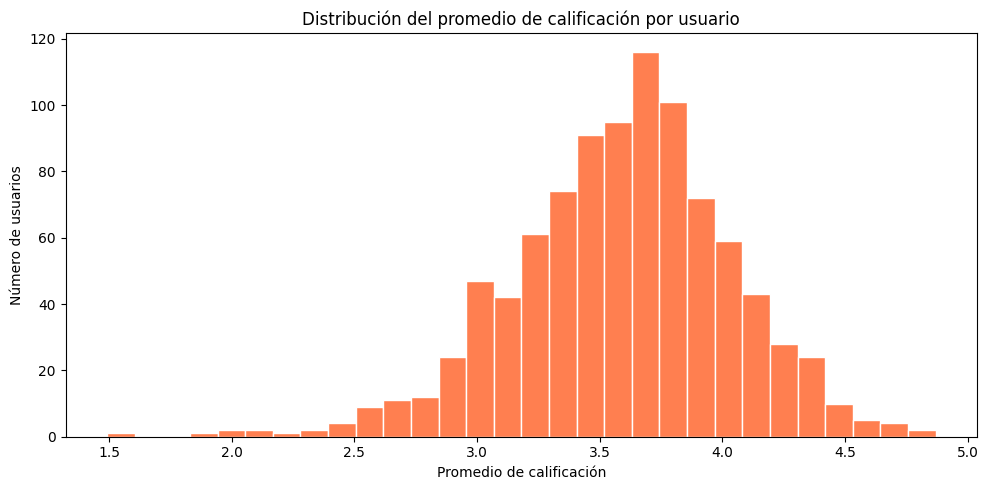

count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: rating, dtype: float64


In [9]:
avg_rating_per_user = ratings.groupby('user_id')['rating'].mean()

plt.figure(figsize=(10, 5))
plt.hist(avg_rating_per_user, bins=30, color='coral', edgecolor='white')
plt.title('Distribución del promedio de calificación por usuario')
plt.xlabel('Promedio de calificación')
plt.ylabel('Número de usuarios')
plt.tight_layout()
plt.show()

print(avg_rating_per_user.describe())

##En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones. 

In [ ]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?  

¿Se puede observar el fenomeno de cola larga en este dataset?




In [ ]:
mt=ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

In [ ]:
mt

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


#Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [ ]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [ ]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [ ]:
train_set.n_ratings

In [ ]:
len(test_set)

In [ ]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [ ]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [ ]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

In [ ]:
items[items['movie id']==302]

Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [ ]:
test_predictions=algo.test(test_set)

In [ ]:
#5 primeras predicciones
test_predictions[0:5]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [ ]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

##Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [ ]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

In [ ]:
#10 primeras predicciones
predictions[0:10]

In [ ]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [ ]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [ ]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [ ]:
user_predictions

In [ ]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [ ]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [ ]:
ratings['user_id'].max()+1